In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [3]:
class ResultState(TypedDict):
    value1: int
    value2: int
    result: int

In [4]:
def add(state: ResultState) -> ResultState:
    state['result'] = state['value1'] + state['value2']
    return state

def sub(state: ResultState) -> ResultState:
    state['result'] = state['value1'] - state['value2']
    return state

In [5]:
seq_graph = StateGraph(ResultState)
seq_graph.add_node("add", add)
seq_graph.add_node("sub", sub)
seq_graph.set_entry_point("add")
seq_graph.add_edge("add", "sub")
seq_graph.set_finish_point("sub")
graph = seq_graph.compile()

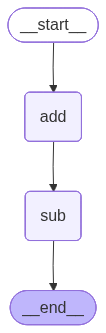

In [6]:
from utils import draw_graph
draw_graph(graph)

In [7]:
state = ResultState(value1 = 10, value2= 3)
result = graph.invoke(state)
print(result)

{'value1': 10, 'value2': 3, 'result': 7}


# To prevent overriting 

##Approach 1 have different values in state
```python
class ResultState(TypedDict):
    value1: int
    value2: int
    add_result: int
    sub_result: int
```

## Approach 2 use list for results
```python
class ResultState(TypedDict):
    value1: int
    value2: int
    result: list[int]
    # result: dict[str, int]
```

In [8]:
## different ways of calling graphs

## use dictionary syntaxes
#state = ResultState(value1 = 10, value2= 3)
result = graph.invoke({"value1": 10, "value2": 3})
print(result)

{'value1': 10, 'value2': 3, 'result': 7}


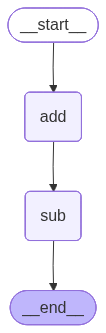

In [10]:
# It is not necessary that every node has to return the complete state
# partial updates are also ok

class ResultState(TypedDict):
    value1: int
    value2: int
    add_result: int
    sub_result: int

    
# nodes with partial updates
def add(state: ResultState):
    return { "add_result": state['value1'] + state['value2']}

def sub(state: ResultState):
    return { "sub_result": state['value1'] - state['value2']}

seq_graph = StateGraph(ResultState)
seq_graph.add_node("add", add)
seq_graph.add_node("sub", sub)
seq_graph.set_entry_point("add")
seq_graph.add_edge("add", "sub")
seq_graph.set_finish_point("sub")
graph = seq_graph.compile()

draw_graph(graph)

In [11]:
result = graph.invoke({"value1": 10, "value2": 3})

In [12]:
result

{'value1': 10, 'value2': 3, 'add_result': 13, 'sub_result': 7}

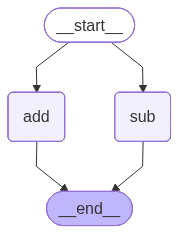

In [13]:
class ResultState(TypedDict):
    value1: int
    value2: int
    add_result: int
    sub_result: int

    
# nodes with partial updates
def add(state: ResultState):
    return { "add_result": state['value1'] + state['value2']}

def sub(state: ResultState):
    return { "sub_result": state['value1'] - state['value2']}

seq_graph = StateGraph(ResultState)
seq_graph.add_node("add", add)
seq_graph.add_node("sub", sub)
seq_graph.add_edge(START, "add")
seq_graph.add_edge("add", END)
seq_graph.add_edge(START, "sub")
seq_graph.add_edge("sub", END)
graph = seq_graph.compile()

draw_graph(graph)

In [14]:
result = graph.invoke({"value1": 10, "value2": 3})

In [15]:
result

{'value1': 10, 'value2': 3, 'add_result': 13, 'sub_result': 7}

In [1]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain.messages import AIMessage, HumanMessage, SystemMessage

In [2]:
class MyState(MessagesState):
    pass

In [3]:
def human_node(state: MyState):
    return { "messages": [HumanMessage("How are you")]}

def system_node(state: MyState):
    return { "messages": [SystemMessage("You are a receptionist at Taj Hotel")] }

def ai_node(state: MyState):
    return {"messages": [AIMessage("Welcome To Taj, I'm doing great")]}

In [4]:
message_graph = StateGraph(MyState)
message_graph.add_node("human", human_node)
message_graph.add_node("system", system_node)
message_graph.add_node("ai", ai_node)

message_graph.add_edge(START, "human")
message_graph.add_edge(START, "system")
message_graph.add_edge(START, "ai")

message_graph.add_edge("human", END)
message_graph.add_edge("system", END)
message_graph.add_edge("ai", END)
graph = message_graph.compile()

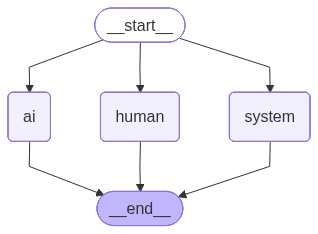

In [5]:
from utils import draw_graph

draw_graph(graph)

In [6]:
response = graph.invoke({"messages": []})

In [7]:
response

{'messages': [AIMessage(content="Welcome To Taj, I'm doing great", additional_kwargs={}, response_metadata={}, id='9d7bfcdf-b041-4dad-948f-de40f6e3b0d9'),
  HumanMessage(content='How are you', additional_kwargs={}, response_metadata={}, id='d30387fd-d8bb-4043-ac1c-0a7c06208dcd'),
  SystemMessage(content='You are a receptionist at Taj Hotel', additional_kwargs={}, response_metadata={}, id='f0b16b39-9acd-429d-b1a1-a1d5e8024bb0')]}

In [8]:
class EmailState(MessagesState):
    draft: str

In [9]:
from utils import get_llm
llm = get_llm()

In [10]:
llm.invoke("What is capital of france")

AIMessage(content='The capital of France is **Paris**.', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 5, 'candidates_token_count': 8, 'total_token_count': 13, 'prompt_tokens_details': [{'modality': 1, 'token_count': 5}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 8}], 'thoughts_token_count': 0, 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.0029188443440943956, 'model_provider': 'google_vertexai', 'model_name': 'gemini-2.5-flash-lite'}, id='lc_run--70e33c14-062e-4a39-a19d-3c3a5964cc62-0', usage_metadata={'input_tokens': 5, 'output_tokens': 8, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [11]:
from langchain_core.prompts import ChatPromptTemplate
def professional_toner(state: EmailState):
    draft = state['draft']
    prompt = ChatPromptTemplate([
        ('system', 'You are an expert email writer'),
        ("user", "Coniser the following draft email {draft} without changing facts and preserving the meaning"),
        ("user", "Rewrite the email in less than 150 words in the professional tone ")
    ])
    chain = prompt | llm 
    return {"messages":  chain.invoke({'draft': draft}) } 

def casual_toner(state: EmailState):
    draft = state['draft']
    prompt = ChatPromptTemplate([
        ('system', 'You are an expert email writer'),
        ("user", "Coniser the following draft email {draft} without changing facts and preserving the meaning"),
        ("user", "Rewrite the email in less than 150 words in the casual tone ")
    ])
    chain = prompt | llm 
    return {"messages":  chain.invoke({'draft': draft}) } 
    

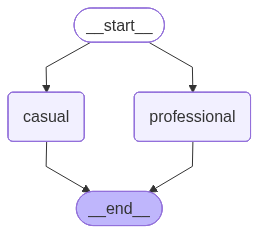

In [12]:
toner_graph = StateGraph(EmailState)
toner_graph.add_node("professional", professional_toner)
toner_graph.add_node("casual", casual_toner)

toner_graph.add_edge(START, "professional")
toner_graph.add_edge(START, "casual")

toner_graph.add_edge("professional",END)
toner_graph.add_edge("casual",END)
graph = toner_graph.compile()
graph

In [13]:
response = graph.invoke({
    "draft": "I want to go for a roadtrip, which may require 5 days of leave. Can you grant me the leave",
    "messages": []
})

In [14]:
response

{'messages': [AIMessage(content="Subject: Road Trip Leave Request - [Your Name]\n\nHey [Manager's Name],\n\nHope you're doing well!\n\nI'm planning a road trip and would love to request 5 days of leave from [Start Date] to [End Date]. This trip is something I've been looking forward to for a while and I think it will be a great chance to recharge.\n\nI'll make sure all my urgent tasks are wrapped up before I go and will prepare a handover for anything outstanding. I'll also be reachable for any absolute emergencies if needed.\n\nLet me know if this works!\n\nThanks,\n\n[Your Name]", additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 59, 'candidates_token_count': 135, 'total_token_count': 194, 'prompt_tokens_details': [{'modality': 1, 'token_count': 59}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 135}], 'thoughts_token_count': 0, 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'fin

In [ ]:
for message in response['messages']:
    message.pretty_print()

================================== Ai Message ==================================

Subject: Road Trip Leave Request - [Your Name]

Hey [Manager's Name],

Hope you're doing well!

I'm planning a road trip and would love to request 5 days of leave from [Start Date] to [End Date]. This trip is something I've been looking forward to for a while and I think it will be a great chance to recharge.

I'll make sure all my urgent tasks are wrapped up before I go and will prepare a handover for anything outstanding. I'll also be reachable for any absolute emergencies if needed.

Let me know if this works!

Thanks,

[Your Name]
================================== Ai Message ==================================

Subject: Leave Request - Roadtrip

Dear [Manager's Name],

I am writing to request five days of leave from [Start Date] to [End Date]. I am planning a personal roadtrip during this period and would like to take advantage of this time for a much-needed break.

I will ensure all my urgent tasks a

: 